In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [2]:
import torch
import torch.optim as optim
from torch.autograd import Variable
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import numpy as np
import math
import time
import sys
from PIL import Image
import matplotlib.pyplot as plt
import torchvision.datasets as datasets
import warnings

sys.path.append("/home/jvkovacikova/master-thesis/main_part")
sys.path.append("..")
from main_part.networks import wide_resnet

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')
torch.cuda.get_device_name()

Using device: cuda


'NVIDIA GeForce RTX 2080 Ti'

In [4]:
def calculate_sparsity(module):
    nonzero = torch.sum(module.weight != 0).item()
    total = module.weight.nelement()
    return 100. * (total - nonzero) / total


def get_sparsity(model):
    total_nonzero = 0
    total_elements = 0
    sparsity_info = {}

    for name, module in model.named_modules():
        if isinstance(module, (torch.nn.Conv2d, torch.nn.Linear, torch.nn.BatchNorm2d)):
            sparsity = calculate_sparsity(module)
            sparsity_info[name + '.weight'] = sparsity
            nonzero = torch.sum(module.weight != 0).item()
            total = module.weight.nelement()
            total_nonzero += nonzero
            total_elements += total

    global_sparsity = 100. * (total_elements - total_nonzero) / total_elements
    sparsity_info['GLOBAL SPARSITY'] = global_sparsity

    return sparsity_info

## Load CIFAR-100 classes

In [5]:
cifar100_dataset = datasets.CIFAR100(root='../main_part/data', download=False)
cifar100_classes = cifar100_dataset.classes

## Load the trained network

In [6]:
path_to_trained_network = '../main_part/checkpoint/cifar100/seed40/gradual_pruning/longer_finetuning/wide_resnet_28x10_40_block_max_sparsity_lrb_finetuning_lastepoch.t7'

In [7]:
checkpoint = torch.load(path_to_trained_network)
net = checkpoint['net']
best_acc = checkpoint['acc']
ep = checkpoint['epoch']
print("Training epochs:", ep)
net.to(device)
net

Training epochs: 400


Wide_ResNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (layer1): Sequential(
    (0): wide_basic(
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv1): Conv2d(16, 160, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (dropout): Dropout(p=0, inplace=False)
      (bn2): BatchNorm2d(160, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(160, 160, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (shortcut): Sequential(
        (0): Conv2d(16, 160, kernel_size=(1, 1), stride=(1, 1))
      )
    )
    (1): wide_basic(
      (bn1): BatchNorm2d(160, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv1): Conv2d(160, 160, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (dropout): Dropout(p=0, inplace=False)
      (bn2): BatchNorm2d(160, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(16

In [8]:
print("Test accuracy of the loaded model: %.2f%%" %(best_acc))

Test accuracy of the loaded model: 79.97%


In [9]:
print("\nSparsity of the model:")
sparsity_info = get_sparsity(net)
for layer, sparsity in sparsity_info.items():
    print(f"Sparsity in {layer}: {sparsity:.2f}%")


Sparsity of the model:
Sparsity in conv1.weight: 0.00%
Sparsity in layer1.0.bn1.weight: 0.00%
Sparsity in layer1.0.conv1.weight: 25.28%
Sparsity in layer1.0.bn2.weight: 0.00%
Sparsity in layer1.0.conv2.weight: 76.61%
Sparsity in layer1.0.shortcut.0.weight: 0.00%
Sparsity in layer1.1.bn1.weight: 0.00%
Sparsity in layer1.1.conv1.weight: 78.11%
Sparsity in layer1.1.bn2.weight: 0.00%
Sparsity in layer1.1.conv2.weight: 75.78%
Sparsity in layer1.2.bn1.weight: 0.00%
Sparsity in layer1.2.conv1.weight: 81.25%
Sparsity in layer1.2.bn2.weight: 0.00%
Sparsity in layer1.2.conv2.weight: 79.78%
Sparsity in layer1.3.bn1.weight: 0.00%
Sparsity in layer1.3.conv1.weight: 79.89%
Sparsity in layer1.3.bn2.weight: 0.00%
Sparsity in layer1.3.conv2.weight: 80.39%
Sparsity in layer2.0.bn1.weight: 0.00%
Sparsity in layer2.0.conv1.weight: 72.76%
Sparsity in layer2.0.bn2.weight: 0.00%
Sparsity in layer2.0.conv2.weight: 85.72%
Sparsity in layer2.0.shortcut.0.weight: 27.00%
Sparsity in layer2.1.bn1.weight: 0.00%
Sp

## Try predicting

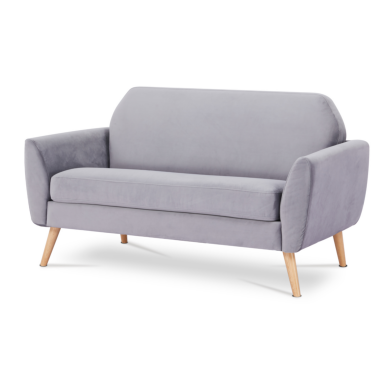

In [10]:
image_path = 'images/sedacka.jpg'
img = Image.open(image_path).convert('RGB')
plt.imshow(img)
plt.axis('off') 
plt.show()

In [11]:
transform = transforms.Compose([
    transforms.Resize((32, 32)),  # Resize to the same size as CIFAR-100 images
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize((0.5071, 0.4865, 0.4409), (0.2673, 0.2564, 0.2761))  # Normalize with CIFAR-100 mean and std
])

img_transformed = transform(img).unsqueeze(0).to(device)

In [13]:
prediction = net(img_transformed).squeeze(0).softmax(0)
class_id = prediction.argmax().item()
score = prediction[class_id].item()
print(f"{cifar100_classes[class_id]}: {100 * score:.1f}%")

couch: 100.0%


/home/jvkovacikova/miniconda3/envs/diplomovka/lib/python3.12/site-packages/torch/nn/modules/conv.py:456: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at /opt/conda/conda-bld/pytorch_1716905969118/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:84.)
  return F.conv2d(input, weight, bias, self.stride,


TOP 10 predicted labels:

In [14]:
top10_prob, top10_catid = torch.topk(prediction, 10)
for i in range(top10_prob.size(0)):
    print(f"{cifar100_classes[top10_catid[i]]}: {top10_prob[i].item():.6f}")

couch: 0.999978
chair: 0.000014
bed: 0.000001
table: 0.000000
willow_tree: 0.000000
pickup_truck: 0.000000
cockroach: 0.000000
keyboard: 0.000000
cattle: 0.000000
leopard: 0.000000
